In [31]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

from scipy.special import softmax

import os

## Own code 
import import_ipynb
import metadata_options
import models_nn

In [2]:
from keras import objectives, backend as K
import keras
import tensorflow as tf

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(
    device_count={ 'CPU': 2 , 'GPU':10},
    inter_op_parallelism_threads=0,
    allow_soft_placement=True,
    gpu_options= {'allow_growth': True, 'visible_device_list': "0,1,2,3,4,5"},
    intra_op_parallelism_threads=0,
))

In [3]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


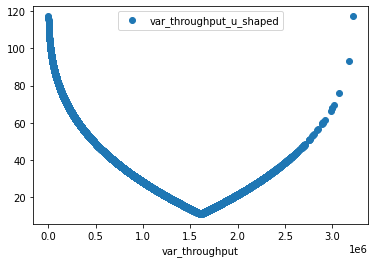

In [4]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_NORM'
k_option_for_tp = 3

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [9]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0

In [10]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [11]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [12]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [13]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [14]:
######################################
## Model Options ##
######################################
# options: bert, distilbert, xlnet, roberta

model_name = 'bert'

In [15]:
def create_simple_trfm_model(model_type, weight_dict):
    if model_type == 'bert':
        model_name = 'bert-base-cased'
        train_batch_size = 64
        learning_rate = 5e-5
    elif model_type == 'distilbert':
        model_name = 'distilbert-base-cased'
        train_batch_size = 16
        learning_rate = 3e-5
    elif model_type == 'xlnet':
        model_name = 'xlnet-base-cased'
        train_batch_size = 16
        learning_rate = 3e-5
    elif model_type == 'roberta':
        model_name = 'roberta-base-cased'
        train_batch_size = 16
        learning_rate = 3e-5
        
    model = ClassificationModel(
        model_type = model_type, 
        model_name = model_name,
        weight=list(weight_dict),
        args={'reprocess_input_data': True,
              'use_cuda':True,
              'num_train_epochs':1,
              'learning_rate': learning_rate,
              'train_batch_size': train_batch_size,
              'overwrite_output_dir': True})
    
    return model

def simple_trfm_indiv_model_tasks(train_df, test_df, annotation_label, model_name, weights_dict, y_test):
    if annotation_label == 'Input.deception_quadrant':
        train_df['Input.deception_quadrant'] = train_df["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        test_df['Input.deception_quadrant'] = test_df["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        annot_train = train_df[['Input.full_text', annotation_label ]]
        annot_train = annot_train.astype({annotation_label: 'int'})
        annot_test = test_df[['Input.full_text', annotation_label ]]
        annot_test = annot_test.astype({annotation_label: 'int'})
    annot_train = train_df[['Input.full_text', annotation_label ]]
    annot_train = annot_train.astype({annotation_label: 'int'})
    annot_test = test_df[['Input.full_text', annotation_label ]]
    annot_test = annot_test.astype({annotation_label: 'int'})

    annot_train = annot_train.rename(columns={'Input.full_text': 'text', annotation_label: 'labels'})
    annot_test = annot_test.rename(columns={'Input.full_text': 'text', annotation_label: 'labels'})

    annot_model = create_simple_trfm_model(model_name, weights_dict)
    annot_model.train_model(annot_train)
    
    train_predictions, train_raw_outputs = annot_model.predict(annot_train['text'].tolist())
    test_predictions, test_raw_outputs = annot_model.predict(annot_test['text'].tolist())
    
    def helper(raw_outputs_list):
        pred = []
        for i in softmax(raw_outputs_list, axis=1):
            pred.append([i[1]])
        pred = np.asarray(pred)
        return pred
    
    print(precision_recall_fscore_support(y_test, test_predictions, average='macro'))

    print(0 in test_predictions)
    
    return helper(train_raw_outputs), helper(test_raw_outputs)

In [16]:
# Rapport model
rapport_pred, rapport_pred_test = simple_trfm_indiv_model_tasks(train, test, 'Answer.3rapport.yes_label', model_name, rapport_class_weight_dict, y_test_rapport)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9092 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/143 [00:00<?, ?it/s]

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


  0%|          | 0/9092 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

(0.4355760773966579, 0.5, 0.4655699177438308, None)
False


/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Gamemove model
gamemove_pred, gamemove_pred_test = simple_trfm_indiv_model_tasks(train, test, 'Answer.1gamemove.yes_label', model_name, gamemove_class_weight_dict, y_test_gamemove)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9092 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/9092 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

(0.4687774846086192, 0.5, 0.4838856105310939, None)
False


In [18]:
# Reasoning model
reasoning_pred, reasoning_pred_test = simple_trfm_indiv_model_tasks(train, test, 'Answer.2reasoning.yes_label', model_name, reasoning_class_weight_dict, y_test_reasoning)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9092 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/9092 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

(0.4109498680738786, 0.5, 0.4511223750905141, None)
False


In [19]:
# Share Information model
shareinfo_pred, shareinfo_pred_test = simple_trfm_indiv_model_tasks(train, test, 'Answer.4shareinformation.yes_label', model_name, share_info_class_weight_dict, y_test_share_information)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9092 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/9092 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

(0.42216358839050133, 0.5, 0.4577968526466381, None)
False


In [20]:
# Deception model
_, _ = simple_trfm_indiv_model_tasks(train, test, 'Answer.3rapport.yes_label', model_name, deception_class_weight_dict, y_test_deception)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

  0%|          | 0/9092 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/9092 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

  0%|          | 0/2274 [00:00<?, ?it/s]

  0%|          | 0/285 [00:00<?, ?it/s]

(0.47537379067722074, 0.5, 0.4873760144274121, None)
False


### One hot encodings

In [21]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [22]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [23]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 7ms/step - loss: 0.6932 - acc: 0.7833 - f1_m: 0.7970 - precision_m: 0.7771 - recall_m: 0.8182 - val_loss: 0.6920 - val_acc: 0.9507 - val_f1_m: 

In [24]:
joint_predict = joint_full_model.predict(pred_test_df_full)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [25]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0.] [2274]


In [26]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6932 - acc: 0.2320 - f1_m: 0.1285 - precision_m: 0.1191 - recall_m: 0.1399 - val_loss: 0.6926 - val_acc: 0.8712 - val_f1_m: 0.

In [27]:
joint_predict = joint_full_model.predict(pred_test_df)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [28]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [104]:
def construct_weighted_dataframe(indices, df_throughput, df_worktime, 
                                 df_agreement, df_textlength, df_special, 
                                 pred_df, pred_df_full):
    pred_df_full_throughput = pred_df_full.copy()
    pred_df_full_worktime = pred_df_full.copy()
    pred_df_throughput = pred_df.copy()
    pred_df_worktime = pred_df.copy()

    df_throughput_keys = df_throughput.keys().to_list()
    throughput_values = df_throughput[df_throughput_keys[-1]].take(indices).values
    pred_df_full_throughput = pred_df_full_throughput.mul(throughput_values, axis=0)
    pred_df_throughput = pred_df_throughput.mul(throughput_values, axis=0)

    df_worktime_keys = df_worktime.keys().to_list()
    worktime_values = df_worktime[df_worktime_keys[-1]].take(indices).values
    pred_df_full_worktime = pred_df_full_worktime.mul(worktime_values, axis=0)
    pred_df_worktime = pred_df_worktime.mul(worktime_values, axis=0)

    df_agreement_keys = df_agreement.keys().to_list()
    if len(df_agreement_keys) == 5:
        agreement_values = df_agreement[df_agreement_keys[-1]].take(indices).values
        pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values.values, axis=0)
        pred_df_agreement = pred_df_throughput.mul(agreement_values.values, axis=0)
    elif len(df_agreement_keys) == 4:
        agreement_values = df_agreement.take(indices)
        pred_df_full_agreement = pred_df_full_throughput.mul(agreement_values.values, axis=0)
        agreement_values_wo_rapport = agreement_values.drop(columns=['Answer.3rapport.yes_pc_agree'])
        pred_df_agreement = pred_df_throughput.mul(agreement_values_wo_rapport.values, axis=0)

    textlength_values = df_textlength.take(indices).values
    pred_df_full_textlength = pred_df_full_throughput.mul(textlength_values, axis=0)
    pred_df_textlength = pred_df_throughput.mul(textlength_values, axis=0)

    df_special_keys = df_special.keys().to_list()
    special_values = df_special[df_special_keys[-1]].take(indices).values
    pred_df_full_special = pred_df_full_throughput.mul(special_values, axis=0)
    pred_df_special = pred_df_throughput.mul(special_values, axis=0)
    
    return pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special

In [105]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [107]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [42]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
#                                callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6940 - acc: 0.3003 - f1_m: 0.3992 - precision_m: 0.8689 - recall_m: 0.2806 - val_loss: 0.7002 - val_

In [43]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

(0.4962109387194456, 0.47994994713889255, 0.34748652604963737, None)

In [44]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1244 1030]


In [45]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [46]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6867 - acc: 0.8236 - f1_m: 0.8974 - precision_m: 0.8640 - recall_m: 0.9369 - val_loss: 0.6549 - val_ac

In [47]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5483201779058458, 0.6075877836029309, 0.47251664032412455, None)

In [48]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1157 1117]


## WorkTime only

### Joint Model with one hot encoding 

In [49]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.8071 - f1_m: 0.8238 - precision_m: 0.8029 - recall_m: 0.8462 - val_loss: 0.6919 - val_ac

In [50]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [51]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [52]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6934 - acc: 0.7665 - f1_m: 0.8425 - precision_m: 0.8664 - recall_m: 0.8704 - val_loss: 0.6881 - val_acc:

In [53]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.49655067155067156, 0.49883190652495635, 0.4853832916978802, None)

In [54]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [  90 2184]


## PC Agreement only

### Joint Model with one hot encoding 

In [109]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.0599 - f1_m: 0.0184 - precision_m: 0.2861 - recall_m: 0.0130 - val_loss: 0.6949 - va

In [110]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.4355760773966579, 0.5, 0.4655699177438308, None)

In [111]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [112]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [113]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 4ms/step - loss: 0.6932 - acc: 0.7389 - f1_m: 0.7739 - precision_m: 0.7190 - recall_m: 0.8392 - val_loss: 0.6931 - val

In [114]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5876754782922138, 0.6156593439725171, 0.5966559455113045, None)

In [115]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [ 411 1863]


## Text Length only

### Joint Model with one hot encoding 

In [62]:
# print('Joint full model with one hot encoding, predicting deception, weighted by text length')
# joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
# joint_full_model.summary()
# history = joint_full_model.fit(x=pred_df_full_textlength, 
#                                y=y_train_deception, 
#                                epochs=32, 
#                                batch_size=64, 
#                                validation_data=(pred_df_full_textlength_test,y_test_deception), 
# #                                callbacks=[models_nn.callback],
#                                class_weight=deception_class_weight_dict)

In [63]:
# joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
# # joint_predict_round = []
# # for a in joint_predict:
# #     joint_predict_round.append(np.argmax(a))
# joint_predict_round = joint_predict.round()
# precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

In [64]:
# uni, cnt = np.unique(joint_predict_round, return_counts=True)
# print(uni, cnt)

In [65]:
# print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
# joint_full_model = models_nn.create_joint_model(pred_df_textlength)
# joint_full_model.summary()
# history = joint_full_model.fit(x=pred_df_textlength, 
#                                y=y_train_rapport, 
#                                epochs=32, 
#                                batch_size=64, 
#                                validation_data=(pred_df_textlength_test,y_test_rapport), 
# #                                callbacks=[models_nn.callback], 
#                                class_weight=rapport_class_weight_dict)

In [66]:
# joint_predict = joint_full_model.predict(pred_df_textlength_test)
# # joint_predict_round = []
# # for a in joint_predict:
# #     joint_predict_round.append(np.argmax(a))
# joint_predict_round = joint_predict.round()
# precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

In [67]:
# uni, cnt = np.unique(joint_predict_round, return_counts=True)
# print(uni, cnt)

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [68]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
#                                callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6932 - acc: 0.9446 - f1_m: 0.9671 - precision_m: 0.9430 - recall_m: 0.9930 - val_loss: 0.6917 - 

In [69]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

/home/kokil/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.47537379067722074, 0.5, 0.4873760144274121, None)

In [70]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[1.] [2274]


In [71]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [72]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
#                                callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7086 - acc: 0.4700 - f1_m: 0.5363 - precision_m: 0.7064 - recall_m: 0.4645 - val_loss: 0.7053 - va

In [73]:
joint_predict = joint_full_model.predict(pred_df_special_test)
# joint_predict_round = []
# for a in joint_predict:
#     joint_predict_round.append(np.argmax(a))
joint_predict_round = joint_predict.round()
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.5197601967616315, 0.5332200271176862, 0.3207627871719315, None)

In [74]:
uni, cnt = np.unique(joint_predict_round, return_counts=True)
print(uni, cnt)

[0. 1.] [1700  574]
